In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from category_encoders import OneHotEncoder
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

# Prepare Data

## Import

In [2]:
df = pd.read_csv("../input/titanic/train.csv", index_col="PassengerId")
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


## Explore

In [4]:
# Find feature with high null counts
df.isnull().sum()/len(df)

Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64

In [5]:
# Drop feature with high null counts
df.drop(columns="Cabin", inplace=True)

In [6]:
# Find low- and high- cardinality categorical variables
df.select_dtypes("object").nunique()

Name        891
Sex           2
Ticket      681
Embarked      3
dtype: int64

In [7]:
# Drop low- and high- cardinality categorical variables
df.drop(columns=["Name","Ticket"], inplace=True)

In [8]:
# Find and drop columns with multicollinearlity, multicollinearity, that is, features in our feature matrix that are highly correlated with each other
df.select_dtypes("number").nunique()

Survived      2
Pclass        3
Age          88
SibSp         7
Parch         7
Fare        248
dtype: int64

In [9]:
# Change Pclass, SibSp and Parch to categorical data since they are ordinal catergorical data
df = df.astype({"Pclass":'object',"SibSp":'object',"Parch": 'object'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    object 
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    object 
 5   Parch     891 non-null    object 
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(1), object(5)
memory usage: 62.6+ KB


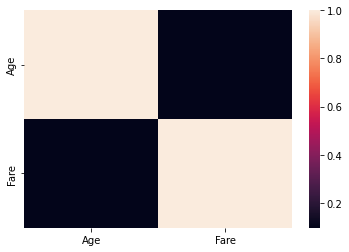

In [10]:

# Drop target column "Survived" and 3 categorical columns "Pclass","SibSp", "Parch" to see correlation between number type columns
corr = df.select_dtypes("number").drop(columns=["Survived"]).corr()
sns.heatmap(corr);

Checked and didn't find any leaky columns 

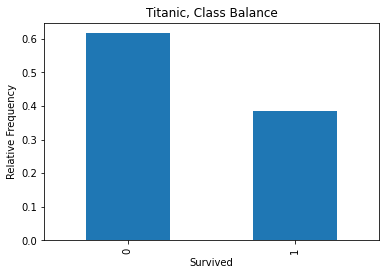

In [11]:
# Check balance dataset by create bar chart
df["Survived"].value_counts(normalize=True).plot(
    kind="bar", xlabel="Survived", ylabel="Relative Frequency", title="Titanic, Class Balance");

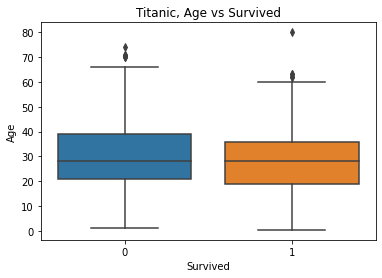

In [12]:
# The relationship between age and survived status
sns.boxplot(x="Survived", y="Age", data=df)
plt.xlabel("Survived")
plt.ylabel("Age")
plt.title("Titanic, Age vs Survived");

In [13]:
# Passenger with certain sex high rate to survive ?
sex_pivot = pd.pivot_table(
        df, index= "Sex", values="Survived", aggfunc=np.mean
).sort_values(by="Survived")
sex_pivot

,Survived
Sex,
male,0.188908
female,0.742038


## Split Data  

In [14]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

In [15]:
target = "Survived"
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked']
X = df[features]
y = df[target]

In [16]:
X_train, X_val, y_train, y_val = train_test_split(
    X,y, test_size=0.2, random_state= 42)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (712, 7)
y_train shape: (712,)
X_val shape: (179, 7)
y_val shape: (179,)


# Build Model

## Baseline

In [17]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.62


## Iterate

In [18]:
# Create logistic regression to predict survival rate
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    LogisticRegression(max_iter=1000))
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Pclass', 'Sex', 'SibSp', 'Parch',
                                     'Embarked'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [19]:
# Try decision tree model, test hyperparameter from 1-15
depth_hyperparams = range(1, 16)
training_acc = []
validation_acc = []
for d in depth_hyperparams:
    model_dt = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(),
        DecisionTreeClassifier(max_depth=d, random_state=42)
    )
    model_dt.fit(X_train, y_train)
    training_acc.append(model_dt.score(X_train, y_train))
    validation_acc.append(model_dt.score(X_val, y_val))
    

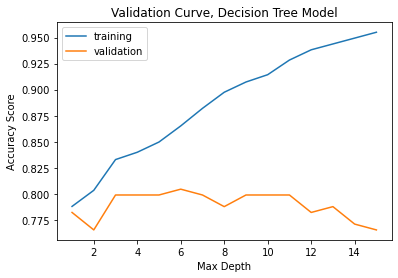

In [20]:
# Plot training accuracy score and validation score for choosing max_depth
plt.plot(depth_hyperparams,training_acc, label="training")
plt.plot(depth_hyperparams,validation_acc, label="validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Validation Curve, Decision Tree Model")
plt.legend();

In [21]:
# Chose max_depth is 6
final_model_dt = make_pipeline(
        OrdinalEncoder(),
        SimpleImputer(),
        DecisionTreeClassifier(max_depth=6, random_state=42)
    )

final_model_dt.fit(X_train, y_train)


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Pclass', 'Sex', 'SibSp', 'Parch',
                                      'Embarked'],
                                mapping=[{'col': 'Pclass',
                                          'data_type': dtype('O'),
                                          'mapping': 1.0    1
2.0    2
3.0    3
NaN   -2
dtype: int64},
                                         {'col': 'Sex', 'data_type': dtype('O'),
                                          'mapping': male      1
female    2
NaN      -2
dtype: int64},
                                         {'col': 'SibSp',
                                          'data_type': dtype('O'),
                                          'mapping': 0.0    1
1.0    2
4.0    3
3.0    4
2.0    5
8.0    6
5.0    7
NaN   -2
dtype: int64},
                                         {'col': 'Parch',
                                          'data_type': dtype('O'),
                                    

# Evaluate

In [22]:
lr_train_acc = accuracy_score(y_train, model_lr.predict(X_train))
lr_val_acc = model_lr.score(X_val, y_val)

print("Logistic Regression, Training Accuracy Score:", lr_train_acc)
print("Logistic Regression, Validation Accuracy Score:", lr_val_acc)

Logistic Regression, Training Accuracy Score: 0.8146067415730337
Logistic Regression, Validation Accuracy Score: 0.7988826815642458


In [23]:
dt_train_acc = accuracy_score(y_train, final_model_dt.predict(X_train))
dt_val_acc = final_model_dt.score(X_val, y_val)
print("Decision Tree, Training Accuracy Score::", dt_train_acc)
print("Decision Tree, Validation Accuracy Score:", dt_val_acc)

Decision Tree, Training Accuracy Score:: 0.8651685393258427
Decision Tree, Validation Accuracy Score: 0.8044692737430168


Chose Decision Tree model is final model

In [24]:
read_test_file = pd.read_csv("../input/titanic/test.csv")
X_test = read_test_file[features]
y_test_pred = final_model_dt.predict(X_test)
submission = pd.DataFrame(
    {"PassengerId": read_test_file["PassengerId"],
        "Survived": y_test_pred})
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [25]:
#submission.to_csv("./Titanic/submission01.csv",index=False)

# Communicate

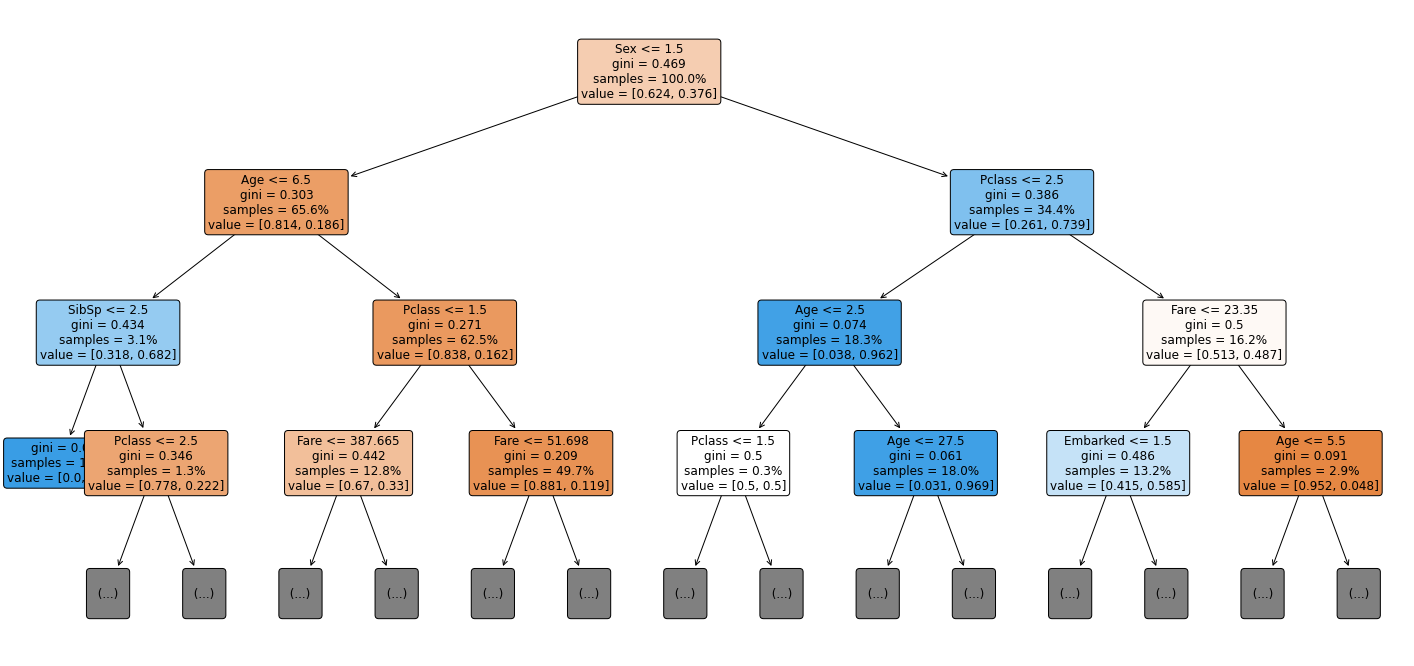

In [26]:
# Visualize the decision logic for decision tree model
# Create larger figure
fig, ax = plt.subplots(figsize=(25, 12))
# Plot tree
plot_tree(
    decision_tree= final_model_dt.named_steps['decisiontreeclassifier'],
    feature_names= X_train.columns,
    filled=True,  # Color leaf with class
    rounded=True,  # Round leaf edges
    proportion=True,  # Display proportion of classes in leaf
    max_depth=3,  # Only display first 3 levels
    fontsize=12,  # Enlarge font
    ax=ax,  # Place in figure axis
);

In [27]:
features = X_train.columns
importances = final_model_dt.named_steps['decisiontreeclassifier'].feature_importances_

print("Features:", features[:3])
print("Importances:", importances[:3])

Features: Index(['Pclass', 'Sex', 'Age'], dtype='object')
Importances: [0.18759982 0.50704316 0.09814824]


In [28]:
feat_imp = pd.Series(importances,index=features).sort_values()
feat_imp.head()

Parch       0.002154
Embarked    0.012159
SibSp       0.034980
Age         0.098148
Fare        0.157916
dtype: float64

Text(0.5, 1.0, 'Titanic Decision Tree, Feature Importance')

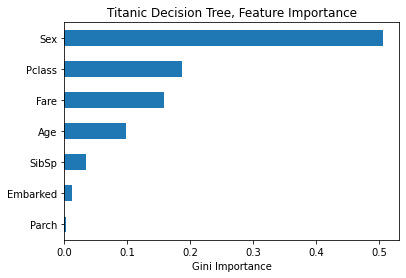

In [29]:
feat_imp.plot(kind='barh')
plt.xlabel("Gini Importance")
plt.title("Titanic Decision Tree, Feature Importance")